In [138]:
import pandas as pd
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

# Get Cleaned Data

In [4]:
with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
	stage_based_data = pickle.load(cleaned_pickle_file)

In [5]:
random.seed(19104)
random_indices = random.sample(range(len(stage_based_data.data)), int(0.7 * len(stage_based_data.data)))

In [6]:
score_dv = stage_based_data.dvs["score"]
score_dv_train = stage_based_data.dvs["score"][random_indices]
score_dv_test = stage_based_data.dvs["score"][list(set(range(len(stage_based_data.data))) - set(random_indices))]

In [27]:
composition_covariates = pd.concat([stage_based_data.composition_features, stage_based_data.size_feature], axis = 1).reset_index(drop = True)
composition_covariates_train = composition_covariates.loc[random_indices]
composition_covariates_test = composition_covariates.loc[list(set(range(len(stage_based_data.data))) - set(random_indices))]

In [59]:
# ALL task features; this is the 24-dimensional treatment
task_treatment = stage_based_data.task_features
task_treatment_train = task_treatment.loc[random_indices]
task_treatment_test = task_treatment.loc[list(set(range(len(stage_based_data.data))) - set(random_indices))]

In [55]:
# Get the column names and their indices
column_table = pd.DataFrame({'Column Name': composition_covariates.columns,
                             'Index': [f'{i}' for i, _ in enumerate(composition_covariates.columns)]})
column_table['Mean'] = composition_covariates.mean().values
column_table


,Column Name,Index,Mean
0,birth_year_mean,0,1959.264297
1,birth_year_std,1,47.867775
2,CRT_mean,2,0.636784
3,CRT_std,3,0.281998
4,income_max_mean,4,66952.108822
5,income_max_std,5,35038.302820
6,income_min_mean,6,53398.063507
7,income_min_std,7,31339.941493
8,IRCS_GS_mean,8,4.222183
9,IRCS_GS_std,9,0.563020


From https://econml.azurewebsites.net/spec/estimation/dml.html#dmluserguide:
Suppose you have observational (or experimental from an A/B test) historical data, where some treatment(s)/intervention(s)/action(s) **T** were chosen and some outcome(s) **Y** were observed and all the variables **W** that could have potentially gone into the choice of **T**, and simultaneously could have had a direct effect on the outcome **Y** (aka controls or confounders) are also recorded in the dataset.

If your goal is to understand what was the effect of the treatment on the outcome as a function of a set of observable characteristics **X** of the treated samples, then one can use this method.

*What's the equivalent here?*

- **Y**: Score (`score_dv_train`)
- **T**: Task features (you're randomized / "treated" by being required to do a task with specific dimensions) -- `task_treatment_train` for multidimensional or `generate_task_treatment_train` as an example of a single dimension
- **X**: Composition features (covariates of the team; `composition_covariates_train`)
- There are no **W** because the treatments were assigned randomly

In [147]:
task_feature_ates = []
task_feature_ate_lb = []
task_feature_ate_ub = []

for task_feature in task_treatment.columns:

    # fit a causal forest model to estimate the average treatment effect of a task "treatment"
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    """Tunes the major hyperparameters of the final stage causal forest based on out-of-sample R-score performance. 
    It trains small forests of size 100 trees on a grid of parameters and tests the out of sample R-score. 
    After the function is called, then all parameters of self have been set to the optimal hyperparameters found. 
    The estimator however remains un-fitted, so you need to call fit afterwards to fit the estimator with the chosen hyperparameters. 
    The list of tunable parameters can be accessed via the property tunable_params."""
    est.tune(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    est.fit(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)

    """
    https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html#econml.dml.CausalForestDML.marginal_ate
    Calculate the average marginal effect.
    The marginal effect is calculated around a base treatment point and averaged over the population of X.
    """
    ate = est.marginal_ate(task_treatment_test[task_feature], X=composition_covariates_test)
    ate_interval = est.ate_interval(X=composition_covariates_test)

    task_feature_ates.append(ate)
    task_feature_ate_lb.append(ate_interval[0])
    task_feature_ate_ub.append(ate_interval[1])

Co-variance matrix is underdetermined. Inference will be invalid!


In [149]:
# print the resulting ATE's given the task features
ate_by_task_feature = {'Task Feature': task_treatment.columns,
        'ATE': task_feature_ates,
        'ATE_lb': task_feature_ate_lb,
        'ATE_ub': task_feature_ate_ub}

df_ate_by_task_feature = pd.DataFrame(ate_by_task_feature)
df_ate_by_task_feature.sort_values(by = 'ATE', ascending = False)

,Task Feature,ATE,ATE_lb,ATE_ub
4,Q7type_7_battle,47.265366,-9.825501,104.356232
22,Q5creativity_input_1,21.132912,5.441824,36.823999
13,Q17within_sys_sol,20.083253,-53.011356,93.177861
19,Q24eureka_question,19.535265,2.711320,36.359209
8,Q11optimizing,16.903070,-2.886677,36.692818
5,Q8type_8_performance,14.957238,4.214728,25.699747
10,Q14sol_scheme_mul,12.382136,-20.121563,44.885834
15,Q19time_solvability,12.035857,-9.187392,33.259106
14,Q18ans_recog,11.888843,-5.368289,29.145974
16,Q20type_3_type_4,11.697389,-5.251352,28.646130


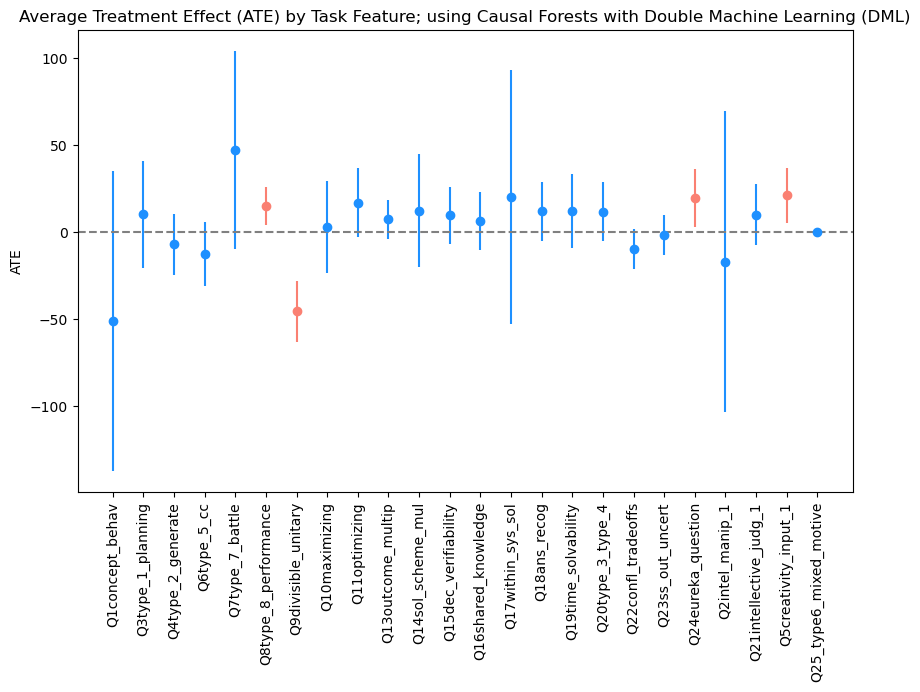

In [162]:
plt.figure(figsize=(10, 6))
for index, row in df_ate_by_task_feature.iterrows():
    # Check if the confidence interval does not include 0; color differently based on that
    if row['ATE_lb'] > 0 or row['ATE_ub'] < 0:
        plt.errorbar(row['Task Feature'], row['ATE'], yerr=[[row['ATE'] - row['ATE_lb']], [row['ATE_ub'] - row['ATE']]], fmt='o', color='salmon')
    else:
        plt.errorbar(row['Task Feature'], row['ATE'], yerr=[[row['ATE'] - row['ATE_lb']], [row['ATE_ub'] - row['ATE']]], fmt='o', color='dodgerblue')

plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('ATE')
plt.title('Average Treatment Effect (ATE) by Task Feature; using Causal Forests with Double Machine Learning (DML)')
plt.show()

In [169]:
def get_task_feature_importances(task_feature, tree_depth=3, min_samples_leaf=10):
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    est.tune(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    est.fit(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    """
    From: https://econml.azurewebsites.net/spec/interpretability.html
    SingleTreeCateInterpreter trains a single shallow decision tree for the treatment effect 
    you learned from any of our available CATE estimators on a small set of feature 
    that you are interested to learn heterogeneity from. The model will split on the cutoff points 
    that maximize the treatment effect difference in each leaf. Finally each leaf will be a subgroup of samples that 
    respond to a treatment differently from other leaves.
    """
    intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=tree_depth, min_samples_leaf=min_samples_leaf)
    # We interpret the CATE model's behavior based on the features used for heterogeneity
    intrp.interpret(est, composition_covariates_train)
    # Plot the tree
    plt.figure(figsize=(25, 10))
    intrp.plot(feature_names=composition_covariates_train.columns, fontsize=12)
    plt.show()

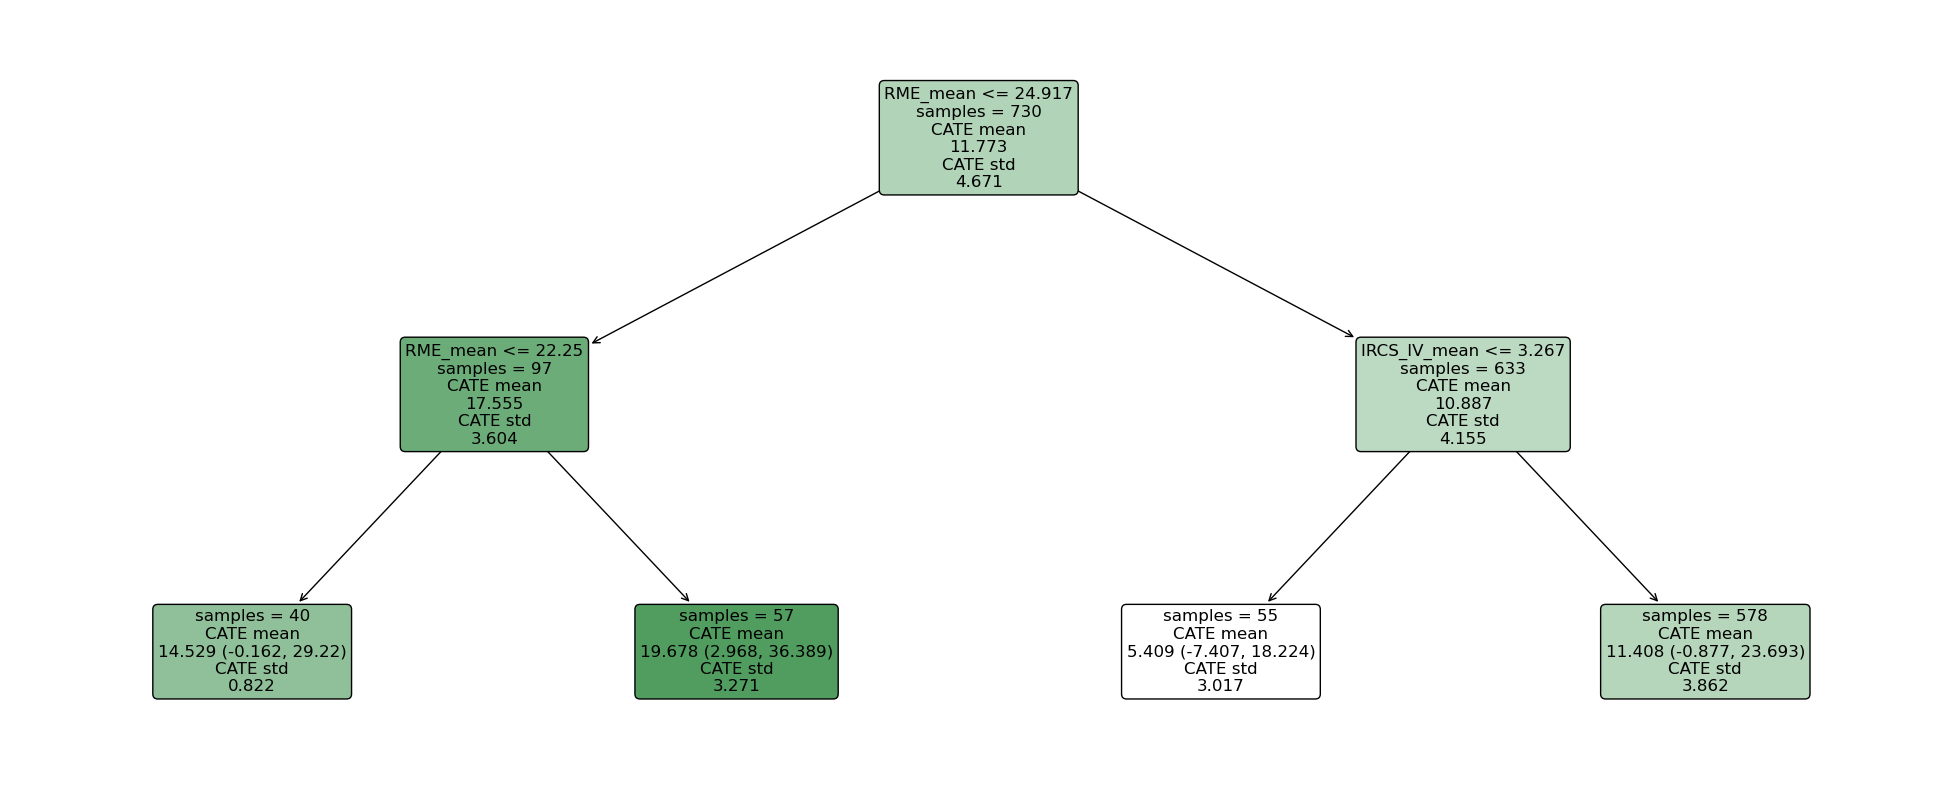

In [170]:
get_task_feature_importances("Q8type_8_performance", tree_depth=2)

# https://github.com/py-why/EconML
# NOTE: "True" goes to the left and "False" goes to the right!

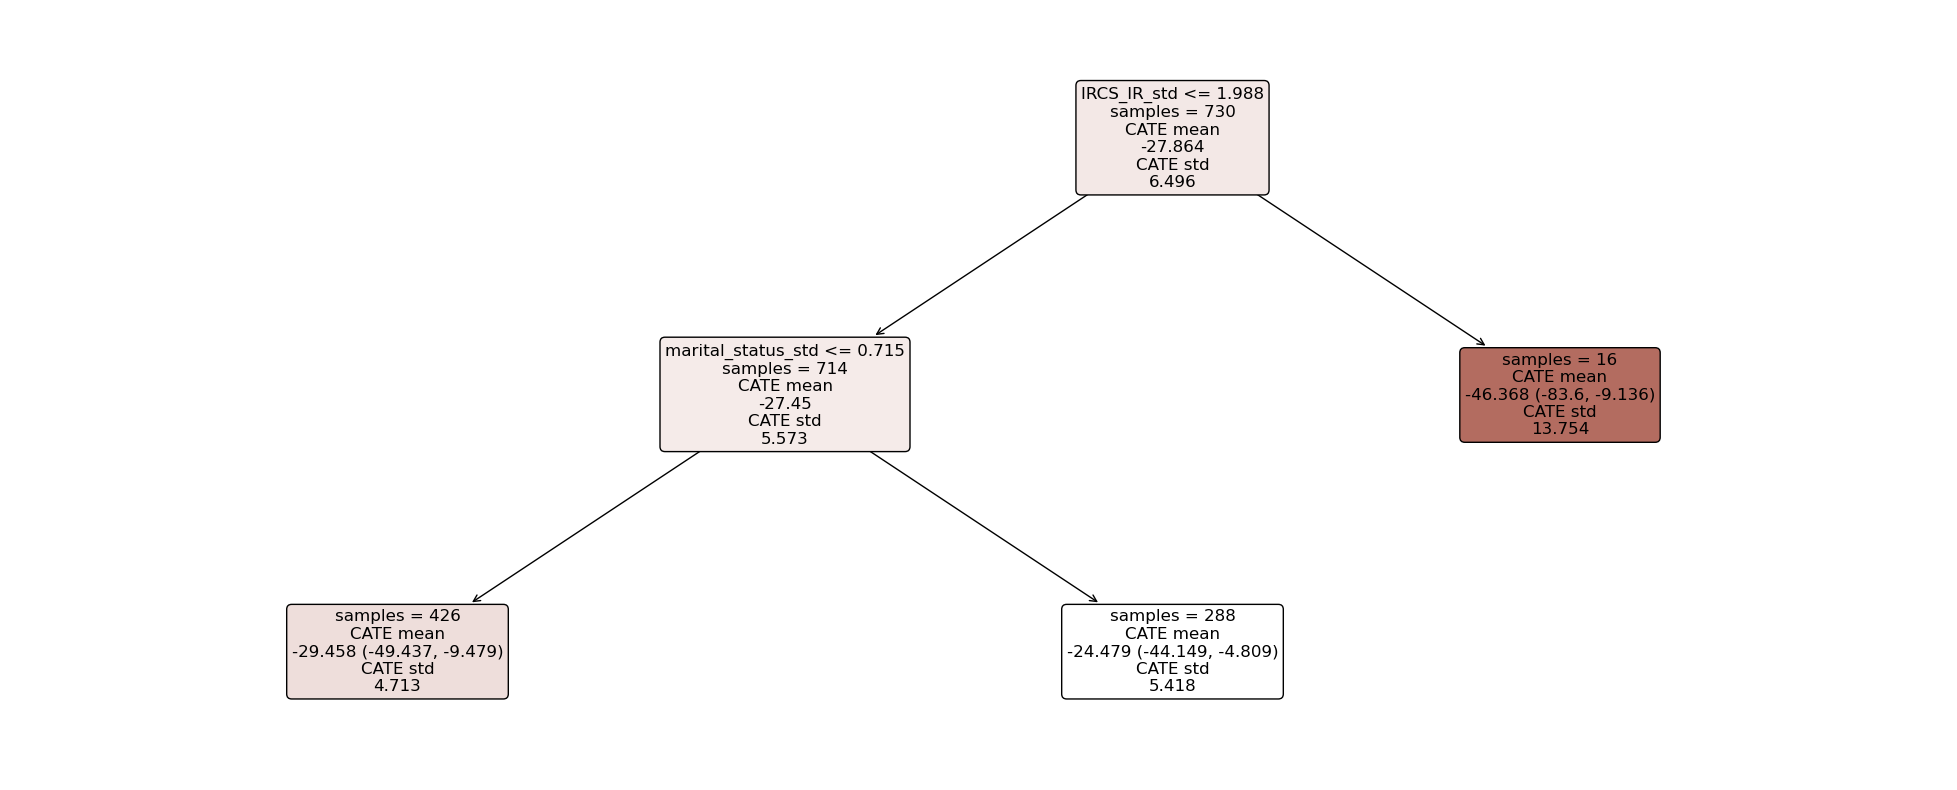

In [171]:
get_task_feature_importances("Q9divisible_unitary", tree_depth=2)

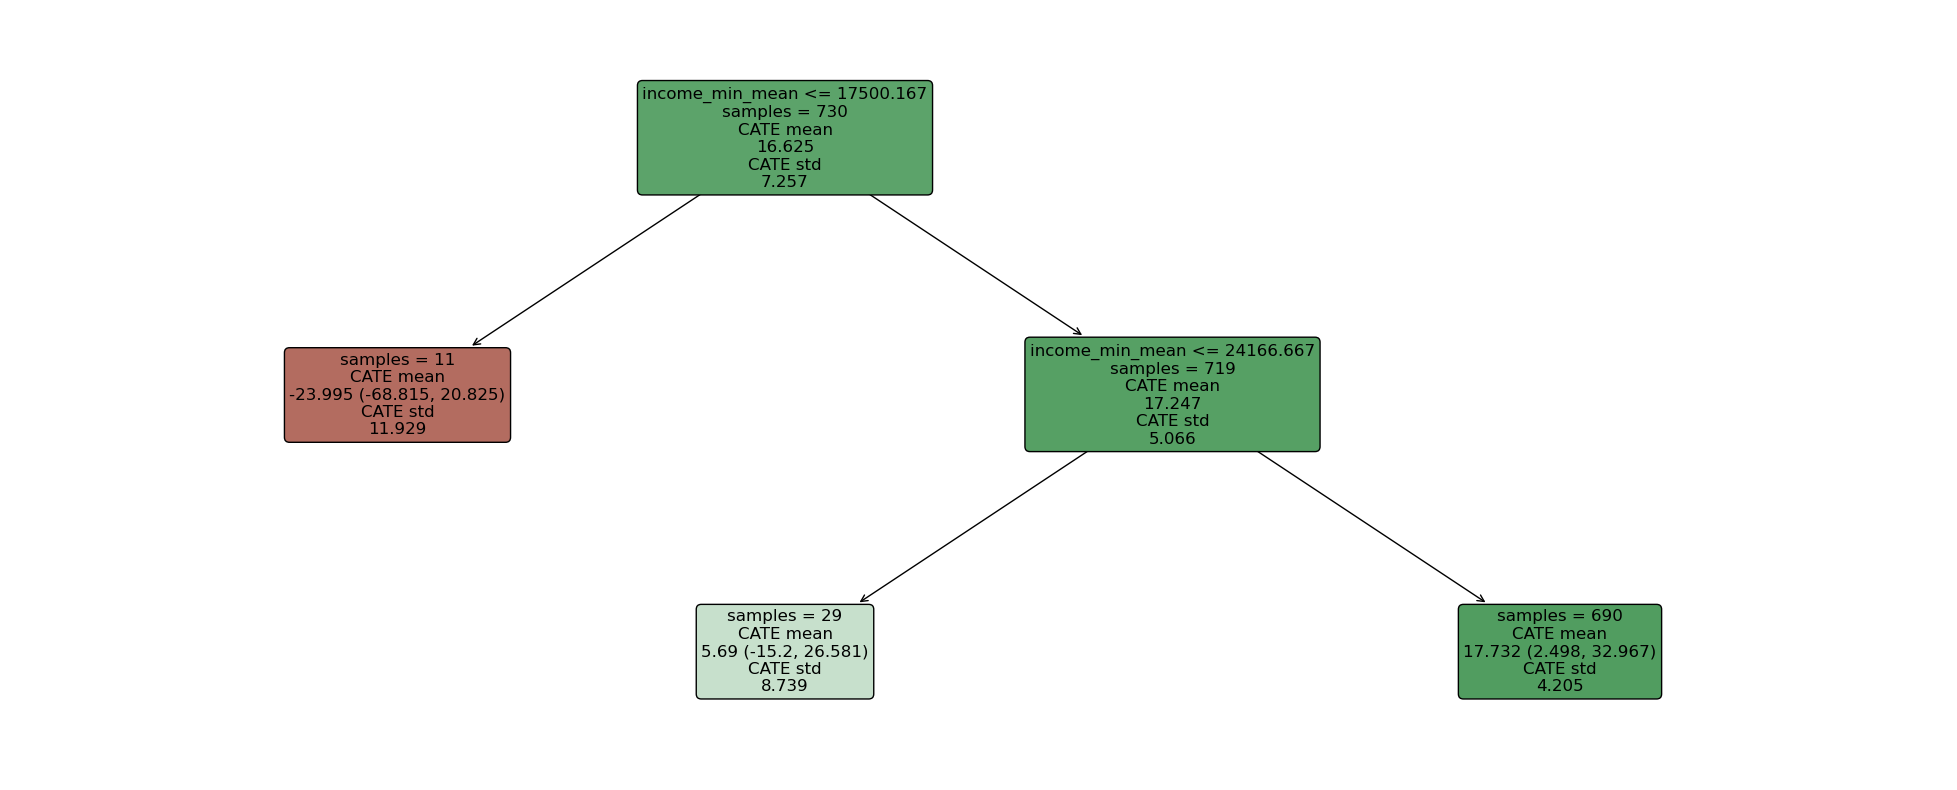

In [172]:
get_task_feature_importances("Q5creativity_input_1", tree_depth=2)

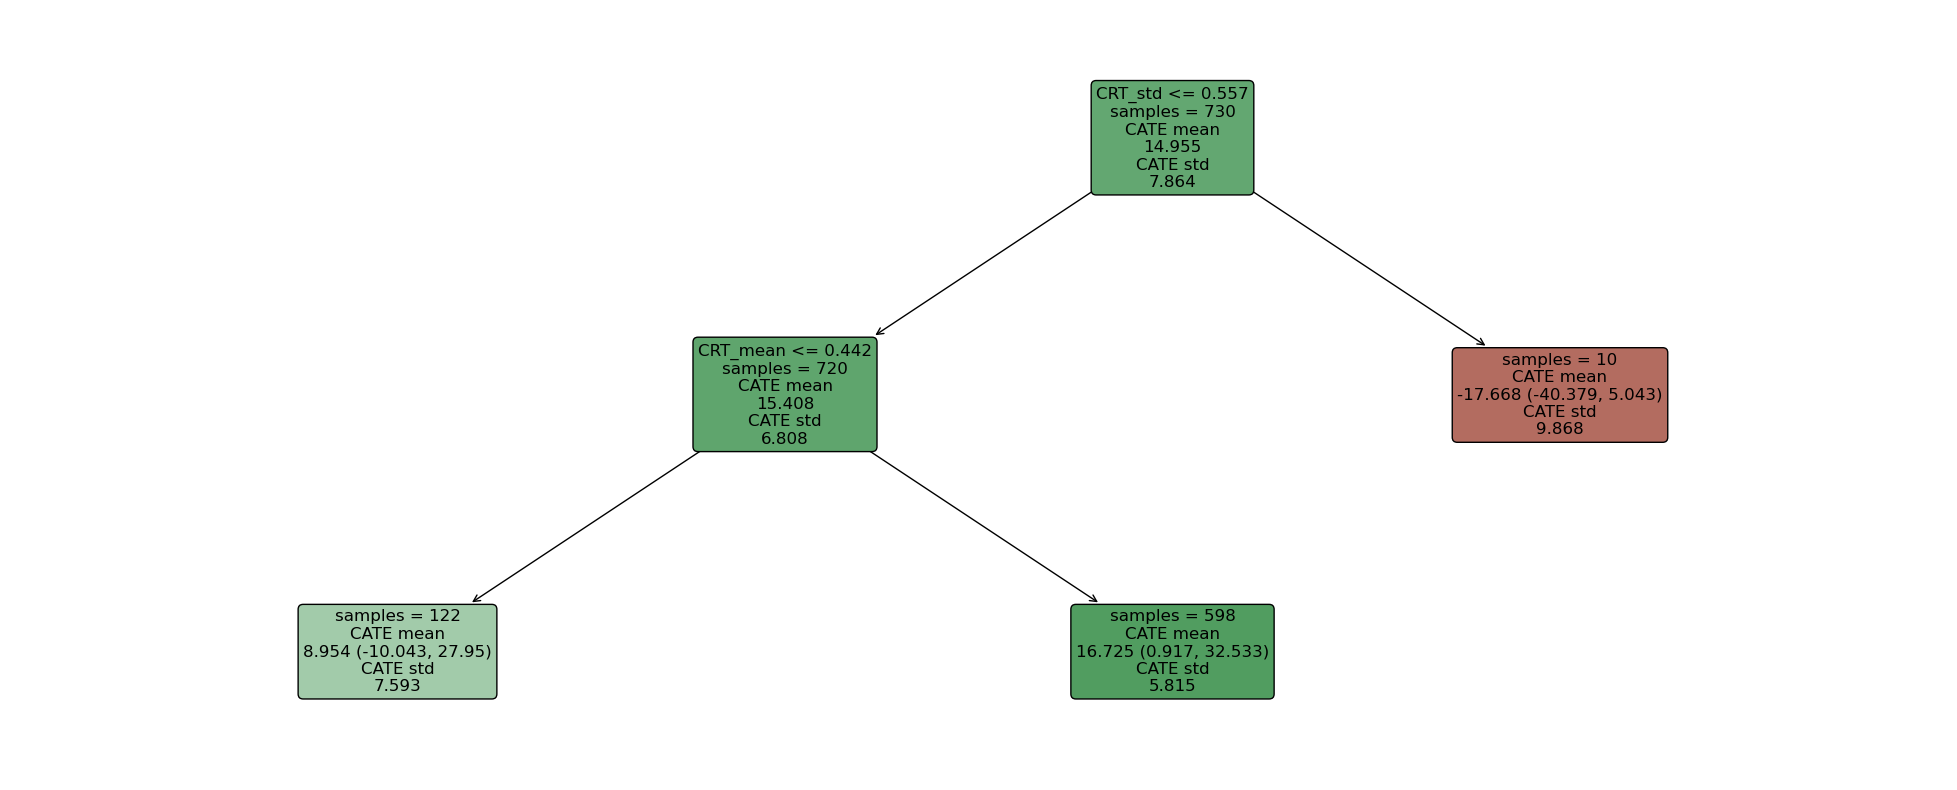

In [173]:
get_task_feature_importances("Q24eureka_question", tree_depth=2)

In [174]:
def get_covariate_importances_for_task_feature(task_feature):
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    est.tune(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    est.fit(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    """
    The feature importances based on the amount of parameter heterogeneity they create. The higher, the more important the feature. 
    The importance of a feature is computed as the (normalized) total heterogeneity that the feature creates. Each split that the feature was chosen adds:
    parent_weight * (left_weight * right_weight)
        * mean((value_left[k] - value_right[k])**2) / parent_weight**2
    to the importance of the feature. Each such quantity is also weighted by the depth of the split. By default splits below max_depth=4 
    are not used in this calculation and also each split at depth depth, is re-weighted by 1 / (1 + depth)**2.0. See the method feature_importances
    for a method that allows one to change these defaults.
    """
    return pd.DataFrame({"covariate": composition_covariates_train.columns,
    "importance": est.feature_importances_}).sort_values(by = "importance", ascending = False)

In [175]:
get_covariate_importances_for_task_feature("Q24eureka_question")

,covariate,importance
3,CRT_std,0.059387
2,CRT_mean,0.056830
29,education_level_std,0.053814
0,birth_year_mean,0.052037
13,IRCS_IB_std,0.045213
10,IRCS_GV_mean,0.039735
1,birth_year_std,0.039316
21,political_fiscal_std,0.033884
16,IRCS_IV_mean,0.033057
7,income_min_std,0.031955
